# Online Joint State and Parameters Estimation for HAR SSM
State space model
\begin{align*}
    &\Theta_{t}^{(1)} = A(\Theta^{(2)})\Theta_{t-1}^{(1)} + \mathbf{p}_{t_{\theta}} \quad \mathbf{p}_{t_{\theta}} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_\theta^{-1}) \\
    &\mathbf{x}_t = A(\Theta_{t}^{(1)})\mathbf{x}_{t-1} + \mathbf{p}_{t_{x}} \quad \mathbf{p}_{t_{x}} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_x^{-1}) \\
    &y_t = \mathbf{c}^\text{T}\mathbf{x}_t + m_t \quad v_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

where
\begin{align*}
    &\Theta^{(1)}_t = (\theta_t, \theta_{t-1}, \dots, \theta_{t-p+1})^\text{T} \quad \Theta^{(1)}_{t-1} = (\theta_{t-1}, \theta_{t-2}, \dots, \theta_{t-p})^\text{T} \\
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\text{T} \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\text{T} 
    \\ \\
    &A(\Theta) = 
    \begin{bmatrix}
         \Theta^{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \quad
    \mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
\end{align*}

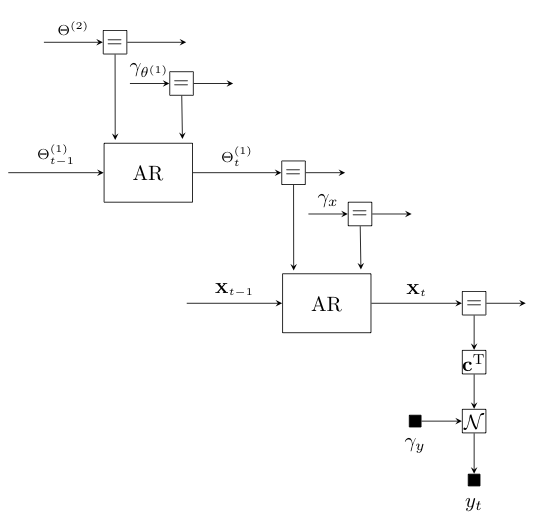

In [1]:
using Images
img = load("../ffgs/HAR-online.png")

In [1]:
using ProgressMeter
using Revise
using ForneyLab
using Random
using Plots
using LaTeXStrings
using StatsPlots
include( "../AR-node/autoregression.jl")
include( "../AR-node/observationAR.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
include("../helpers/functions.jl")
include("../data/ARdata.jl")
import Main.ARdata: generateHAR, generateAR
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [3]:
Random.seed!(0)

HARorder = 2

v_θ1 = 1.0
v_x = 100.0

dataHAR = generateHAR(1000, HARorder, levels=2, nvars=[v_θ1, v_x], stat=true)
θ = [θ[1] for θ in dataHAR[2]]
x = [x[1] for x in dataHAR[3]]

# Observations
v_y = 200.0
y = [xi[1] + sqrt(v_y)*randn() for xi in dataHAR[3]];

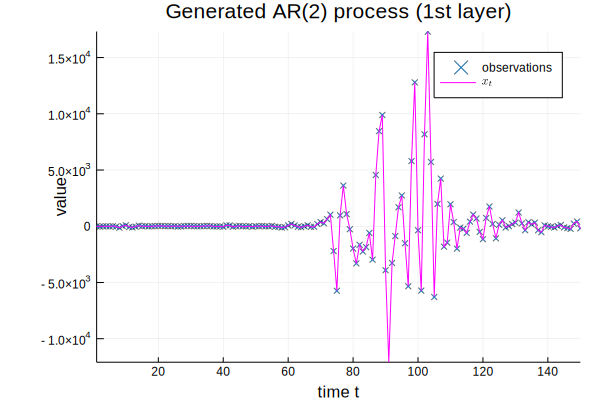

In [664]:
# Plotting the data
from = 1; upto = 150;
plot(xlims=(from, upto), ylims=(minimum(x[from:upto]), maximum(x[from:upto])))
scatter!(y, markershape = :xcross, markeralpha = 0.6,
        markersize = 2, xlabel="time t", ylabel="value", label="observations")
plot!(x, color=:magenta, label=L"x_t", title="Generated AR($HARorder) process (1st layer)")

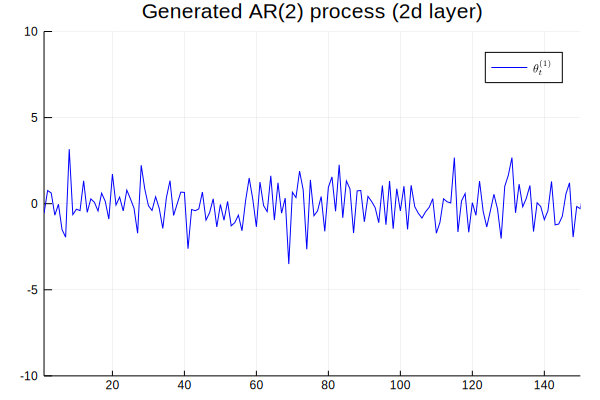

In [665]:
plot(xlims=(from, upto), ylims=(-10, 10))
plot!(θ, color=:blue, label=L"\theta_t^{(1)}", title="Generated AR($HARorder) process (2d layer)")

In [2]:
# AR data

Random.seed!(42)

# Define the order and data
ARorder = 5
diagAR(dim) = Matrix{Float64}(I, dim, dim)

# AR data
v_x = 1.0 # process noise variance
coefs, dataAR = generateAR(1000, ARorder, nvar=v_x, stat=true)
x = [x[1] for x in dataAR]
#dataAR = loadAR("../data/temperature.csv", col=:Temp, delim=",")

v_y = 2.0 # measurement noise variance
# Observations

y = [x[1] + sqrt(v_y)*randn() for x in dataAR];

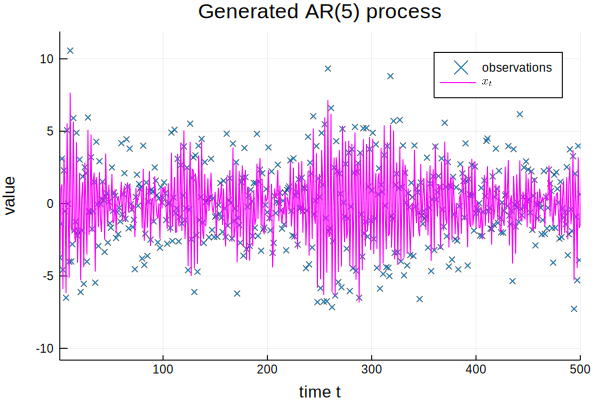

In [655]:
from = 1; upto = 500;
plot(xlims=(from, upto))
scatter!(y, markershape = :xcross, markeralpha = 0.6, markersize = 2, xlabel="time t", ylabel="value", label="observations")
plot!(x, color=:magenta, label=L"x_t", title="Generated AR($ARorder) process")

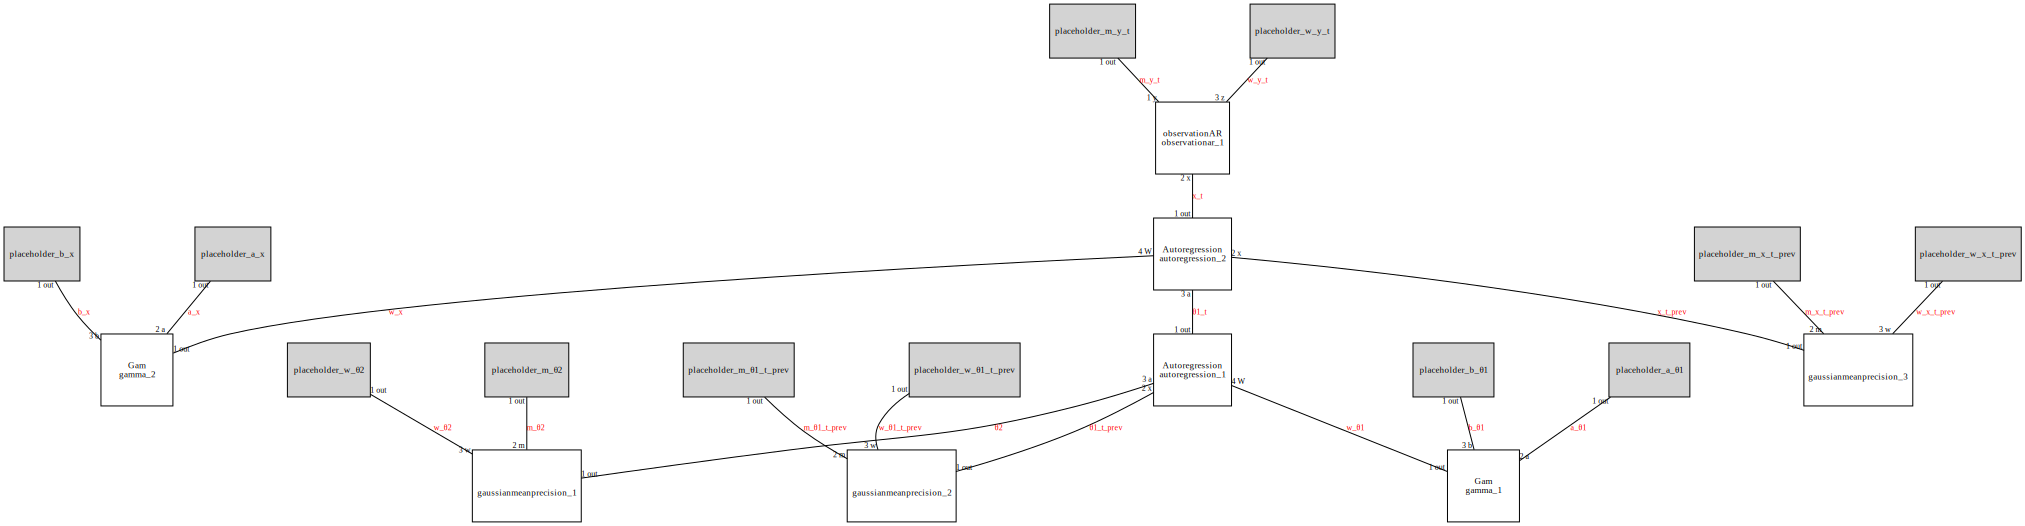

In [666]:
# Creating the graph
g = FactorGraph()

# Upper layer
@RV m_θ2
@RV w_θ2
@RV θ2 ~ GaussianMeanPrecision(m_θ2, w_θ2)
@RV a_θ1
@RV b_θ1
@RV w_θ1 ~ Gamma(a_θ1, b_θ1)
@RV m_θ1_t_prev
@RV w_θ1_t_prev
@RV θ1_t_prev ~ GaussianMeanPrecision(m_θ1_t_prev, w_θ1_t_prev)
@RV θ1_t = AR(θ2, θ1_t_prev, w_θ1)

# Second layer
@RV a_x
@RV b_x
@RV w_x ~ Gamma(a_x, b_x)
@RV m_x_t_prev
@RV w_x_t_prev
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV x_t = AR(θ1_t, x_t_prev, w_x)

# Observation
@RV m_y_t
@RV w_y_t
# FIXME
ARorder = HARorder
observationAR(m_y_t, x_t, w_y_t)

# Placeholders for prior of upper layer
placeholder(m_θ2, :m_θ2, dims=(HARorder,))
placeholder(w_θ2, :w_θ2, dims=(HARorder, HARorder))
placeholder(a_θ1, :a_θ1)
placeholder(b_θ1, :b_θ1)
placeholder(m_θ1_t_prev, :m_θ1_t_prev, dims=(HARorder,))
placeholder(w_θ1_t_prev, :w_θ1_t_prev, dims=(HARorder, HARorder))

# Placeholders for prior of bottom layer
placeholder(a_x, :a_x)
placeholder(b_x, :b_x)
placeholder(m_x_t_prev, :m_x_t_prev, dims=(HARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(HARorder, HARorder))

# Placeholder for observations
placeholder(m_y_t, :m_y_t)
placeholder(w_y_t, :w_y_t)

ForneyLab.draw(g)

In [667]:
# Specify recognition factorization
q = RecognitionFactorization(θ1_t, θ2, θ1_t_prev, w_θ1, x_t, x_t_prev, w_x,
                             ids=[:θ1_t :θ2 :θ1_t_prev :W_θ1 :X_t :X_t_prev :W_x])

algo = variationalAlgorithm(q)
algoF = freeEnergyAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algoF))

freeEnergy (generic function with 1 method)

In [668]:
# Storage for upper layer
m_θ1 = Vector{Vector{Float64}}(undef, length(y))
w_θ1 = Vector{Array{Float64, 2}}(undef, length(y))
m_θ1_prev = Vector{Vector{Float64}}(undef, length(y))
w_θ1_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_θ2 = Vector{Vector{Float64}}(undef, length(y))
w_θ2 = Vector{Array{Float64, 2}}(undef, length(y))
a_θ1 = Vector{Float64}(undef, length(y))
b_θ1 = Vector{Float64}(undef, length(y))

# Storage for bottom layer
m_x = Vector{Vector{Float64}}(undef, length(y))
w_x = Vector{Array{Float64, 2}}(undef, length(y))
a_x = Vector{Float64}(undef, length(y))
b_x = Vector{Float64}(undef, length(y))

# Define values for upper layer
m_θ2_0 = zeros(ARorder)
w_θ2_0 = diagAR(ARorder)
a_θ1_0 = 0.0001
b_θ1_0 = 0.0001
m_θ1_prev_0 = zeros(ARorder)
w_θ1_prev_0 = diagAR(ARorder)
m_θ1_t_0 = zeros(ARorder)
w_θ1_t_0 = diagAR(ARorder)

# Define values for bottom layer
a_x_0 = 0.00001
b_x_0 = 0.00001
m_x_t_prev_0 = zeros(ARorder)
w_x_t_prev_0 = tiny*diagAR(ARorder)

# Priors upper layer
m_θ2_min = m_θ2_0
w_θ2_min = w_θ2_0
a_θ1_min = a_θ1_0
b_θ1_min = b_θ1_0
m_θ1_t_prev_min = m_θ1_prev_0
w_θ1_t_prev_min = w_θ1_prev_0

# Priors bottom layer
a_x_min = a_x_0
b_x_min = b_x_0
m_θ1_t_min = m_θ1_t_0
w_θ1_t_min = w_θ1_t_0
m_x_t_prev_min = m_x_t_prev_0
w_x_t_prev_min = w_x_t_prev_0;

In [669]:
data = Dict()
marginals = Dict()
n_its = 5

# Storage for scores
FHAR = []
logPDFsHAR = []

p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    # Upper Layer
    marginals[:θ2] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_θ2_min, w=w_θ2_min)
    marginals[:θ1_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_θ1_t_prev_min, w=w_θ1_t_prev_min)
    marginals[:θ1_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_θ1_t_min, w=w_θ1_t_min)
    marginals[:w_θ1] = ProbabilityDistribution(Univariate, Gamma, a=a_θ1_min, b=b_θ1_min)
    # Bottom Layer
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w_x] = ProbabilityDistribution(Univariate, Gamma, a=a_x_min, b=b_x_min)

    global m_θ2_min, w_θ2_min, m_θ1_t_prev_min, w_θ1_t_prev_min, a_θ1_min, b_θ1_min,
           m_θ1_t_min, w_θ1_t_min, m_x_t_prev_min, w_x_t_prev_min, a_x_min, b_x_min, data

    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :w_y_t => 10^-1,
                    :m_θ2 => m_θ2_min,
                    :w_θ2 => w_θ2_min,
                    :m_θ1_t_prev => m_θ1_t_prev_min,
                    :w_θ1_t_prev => w_θ1_t_prev_min,
                    :a_θ1 => a_θ1_min,
                    :b_θ1 => b_θ1_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :a_x => a_x_min,
                    :b_x => b_x_min)

        stepX_t!(data, marginals)
        stepX_t_prev!(data, marginals)
        stepW_x!(data, marginals)
        stepθ1_t!(data, marginals)
        stepθ1_t_prev!(data, marginals)
        stepW_θ1!(data, marginals)
        stepθ2!(data, marginals)

        m_θ1_prev[t] = unsafeMean(marginals[:θ1_t_prev])
        w_θ1_prev[t] = unsafePrecision(marginals[:θ1_t_prev])
        m_θ1[t] = unsafeMean(marginals[:θ1_t])
        w_θ1[t] = unsafePrecision(marginals[:θ1_t])
        m_θ2[t] = unsafeMean(marginals[:θ2])
        w_θ2[t] = unsafePrecision(marginals[:θ2])
        a_θ1[t] = marginals[:w_θ1].params[:a]
        b_θ1[t] = marginals[:w_θ1].params[:b]
        m_x[t] = unsafeMean(marginals[:x_t])
        w_x[t] = unsafePrecision(marginals[:x_t])
        a_x[t] = marginals[:w_x].params[:a]
        b_x[t] = marginals[:w_x].params[:b]

        m_θ2_min = m_θ2[t]
        w_θ2_min = w_θ2[t]
        m_θ1_t_prev_min = m_θ1_prev[t]
        w_θ1_t_prev_min = w_θ1_prev[t]
        m_θ1_t_min = m_θ1[t]
        m_θ1_t_min = m_θ1[t]
        m_x_t_prev_min = m_x[t]
        w_x_t_prev_min = w_x[t]
        a_θ1_min = a_θ1[t]
        b_θ1_min = b_θ1[t]
        a_x_min = a_x[t]
        b_x_min = b_x[t]
    end
    push!(logPDFsHAR, logPDF(x[t], m_x[t][1], w_x[t][1]^-1))
    push!(FHAR, (freeEnergy(data, marginals)))
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:01


In [670]:
## Plotting AR coefs first layer
# Extracting estimates for x_t (first component of vector x̄_t)
m_xt = [m_x[1] for m_x in m_x]
v_xt = [v_x[1]^-1 for v_x in w_x]

# Extracting estimates for θ2_t (first component of vector θ̂2_t)
m_θ1t = [m_θ1[1] for m_θ1 in m_θ1]
v_θ1t = [v_x[1]^-1 for v_x in w_θ1];

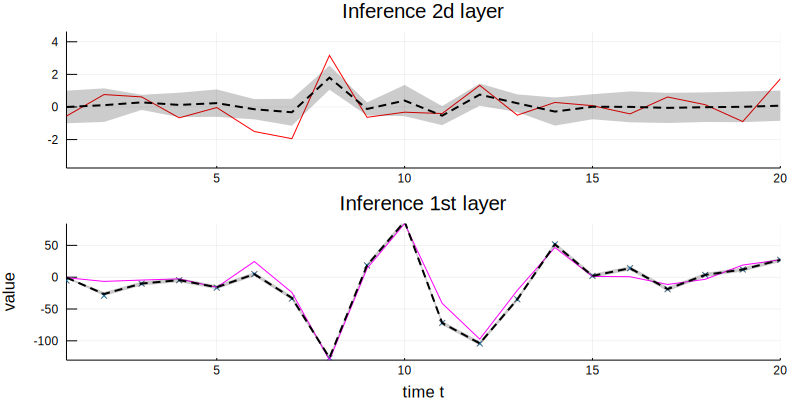

In [671]:
from = 1
upto = 20
scatter(y, markershape = :xcross, markeralpha = 0.6,
        markersize = 2, xlabel="time t", ylabel="value", label="observations")
plot!(xlims=(from, upto), ylims=(minimum(x[from:upto]), maximum(x[from:upto])))
plot!(x, color=:magenta, label=L"x_t", title="Inference 1st layer")
pHAR = plot!(m_xt, ribbon=(sqrt.(v_xt), sqrt.(v_xt)),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")

plot(xlims=(from, upto))
plot!(θ, color=:red, label=L"true \quad \theta^{(1)}", title="Inference 2d layer")
pAR = plot!(m_θ1t, ribbon=(sqrt.(v_θ1t), sqrt.(v_θ1t)),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred", title="Inference 2d layer")

plot(pAR, pHAR, layout=(2,1), size=(800, 400), legend=false)

In [672]:
unsafeCov(marginals[:θ1_t])

2×2 Array{Float64,2}:
  0.0946381    -9.18688e-13
 -9.18688e-13   1.0e-12    

# RW model
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = x_t + m_t \quad m_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

We set $\gamma_y = \frac{1}{2}$

In [3]:
include("../models/AR.jl")
ARorder = 2

2

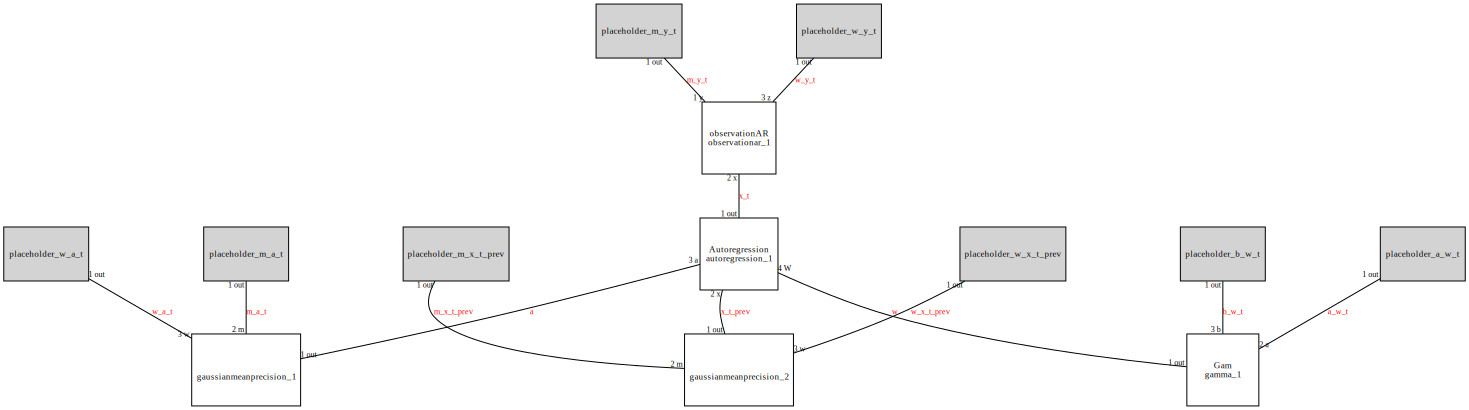

In [4]:
gar, qar = buildGraphAR(ARorder)
setCurrentGraph(gar)
ForneyLab.draw(gar)

In [6]:
prs = Dict(:m_a=>zeros(ARorder), :w_a=>diagAR(ARorder),
           :m_x=>zeros(ARorder), :w_x=>tiny*diagAR(ARorder),
           :a=>0.00001, :b=>0.00001)

# If Julia throws an error just ignore and re-run this (inference) block again
result = inferAR(qar, y, v_y, priors=prs, r_stats=true);

Observed 100%|██████████████████████████████████████████| Time: 0:00:05


In [683]:
# Inspect the results
marginals = result[1]
FAR = result[3]
posteriors = result[4]

m_x = posteriors[:m_x]
w_x = posteriors[:w_x]
m_a = posteriors[:m_a]
w_a = posteriors[:w_a]
a = posteriors[:a]
b = posteriors[:b]

m_ar = [x[1] for x in m_x]
v_ar = [v_x[1]^-1 for v_x in w_x[1:end]];

logPDFsAR = [logPDF(x[t], m_ar[t], v_ar[t]) for t in 1:length(y)]
WMSEsAR = [wmse(x[1:t], [est[1] for est in m_x[1:t]], [est[1]^-1 for est in w_x[1:t]]) for t in 1:length(y)];

In [684]:
println("Process noise variance\n=========")
println("Estimated ", mean(marginals[:w])^-1)
println("True ", 1.0)

println("\nState\n=========")
println("Mean ", mean(marginals[:x_t]))
println("Var ", var(marginals[:x_t]))

Process noise variance
Estimated 9.915525992877803e8
True 1.0

State
Mean [79515.5, 1.17026e5]
Var [200.0, 1.0e-12]


# Comparison (RW vs HAR)
To assess the performance of our model, we use the following metrics:
Free Energy:
$$F_t[q]\triangleq \int q(\mathbf{x}_t)\log\frac{q(\mathbf{x}_t)}{p(\mathbf{x}_t, y_t\big|\mathbf{y}_{1:t-1})}d\mathbf{x}_t$$

log PDF, i.e.:
$$-\frac{1}{2}\log{2\pi v_x}-\frac{(m_{x_{k}}-x_{k})^2}{2v_x}$$

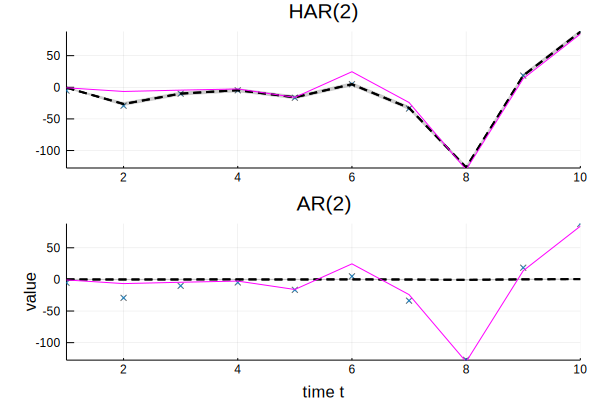

In [689]:
from = 1
upto = 10 # limit for building a graph 
scale = 1.0 # scale for the variance

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([m_ar, m_ar], fillrange=[m_ar - scale .* sqrt.(v_ar), m_ar + scale .* sqrt.(v_ar)],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pAR = plot!(xlabel="time t", ylabel="value", title="AR($ARorder)")


scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([m_xt, m_xt], fillrange=[m_xt - scale .* sqrt.(v_xt), m_xt + scale .* sqrt.(v_xt)],
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pHAR = plot!(title="HAR($HARorder)", legend=false)

plot(pHAR, pAR, xlims=(from, upto), 
    ylims=(minimum(y[from:upto]) - 0.42, maximum(y[from:upto]) + 0.42), 
    layout=(2,1), legend=false)

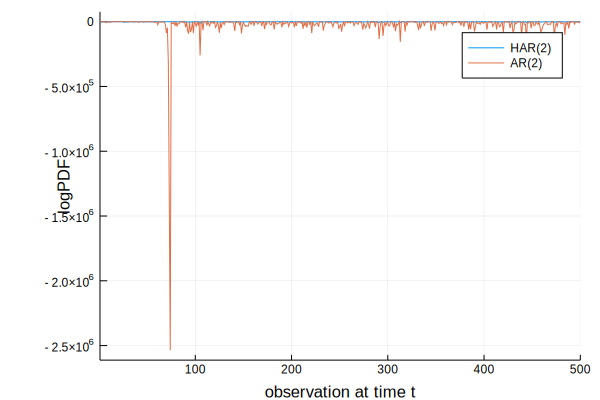

In [680]:
# log PDFs
from = 1; upto = 500
plot(logPDFsHAR[1:end], label="HAR($HARorder)", xlims=(from, upto))
plot!(logPDFsAR[1:end], label="AR($ARorder)", xlabel="observation at time t", ylabel="logPDF", size=(600, 400))

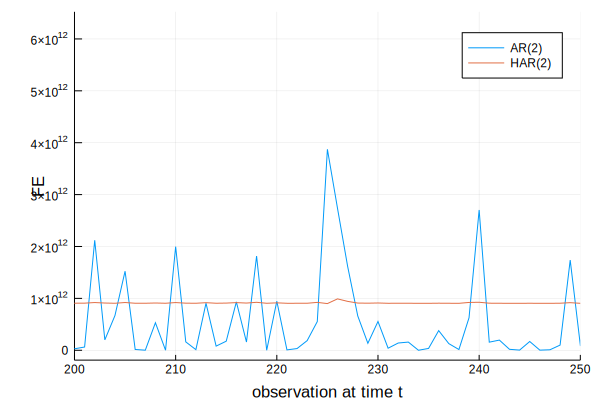

In [648]:
# Free energy
from, upto = 200, 250
plot(FAR[2:end], label="AR($ARorder)", xlims=(from, upto))
plot!(FHAR[2:end], label="HAR($HARorder)", xlabel="observation at time t", ylabel="FE")

In [649]:
sum(logPDFsAR)

-1455.4301775395838

In [650]:
sum(logPDFsHAR)

-1433.9772971428192